## Weather data analyses
Description of where we got the data from, with link to data
Copy the column names and specifications, etc.

In order to obtain data weather for this project, we decided to use the website MeteoStat, whose link is the following:

https://meteostat.net/pt/place/fr/paris?s=07156&t=2022-10-25/2022-11-01

We decided to download all the recorded data for this function according to the instructions presented in the following link: 

https://dev.meteostat.net/bulk/hourly.html#endpoints

This data comes in a CSV format with the following table of features: 

| Order | Parameter | Description | Type|
| --- | --- | --- | --- |
| 1 | date | The date string(YYYY/MM/DD) | string |
| 2 | hour | The hour(UTC) | Integer |
| 3 | temp | Air temperature in ºC | Float |
| 4 | dwpt | The dew point in ºC | Float |
| 5 | rhum | The relative humidity in percentage | Integer |
| 6 | prcp | The one hour precipitation total in mm | Float |
| 7 | snow | The snow depth in mm | Integer | 
| 8 | wdir | The wind direction in degrees | Categorical(Int) |
| 9 | wspd | The average wind speed in km/h | Float |
| 10 | wpgt | The peak wind gust in km/h | Float | 
| 11 | pres | The sea-level  air pressure in hPa | Float | 
| 12 | tsun | The one hour sunshine total in minutes | Integer |
| 13 | coco | The weather condition code | Categorical(Int) |  





This dataset is open-source and the Meteostat developers have written this message in regard to the utilization of the data: 

"Meteostat data is generally provided under the terms of the Creative Commons Attribution-NonCommercial 4.0 International Public License (CC BY-NC 4.0) (opens new window). You may build upon the material for any purpose, even commercially. However, you are not allowed to redistribute Meteostat data "as-is" for commercial purposes outside of the US.

This is due to the policy of WMO resolution 40 (opens new window). According to the resolution, data must be distributed "free and unrestricted" and "at no more than the cost of reproduction and delivery, without charge for the data and products themselves"."

The licence used by Meteostat can be found in the following link: 
https://creativecommons.org/licenses/by-nc/4.0/#

*Disclaimer: This dataset is the work and property of MeteoStat and the weather Station of Paris-Mounsouris(weather station ID:07156), and we are not endorsed by none of these entities. We give all credits to the dataset creators,and we will use and modify the files in accordance with the MeteoStat license.*  




In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def weather_data_prep() -> pd.DataFrame:
    """
    Loading and preparing weather data for further analysis,
    comprising adding column names, selecting the right time range,
    removing columns with only missing values, and concatenating the date and hour
    to make the time format compatible with the bike_counters data. 

    Parameters: ()
    Returns:
        - weather_data (pd.DataFrame): Data containing weather information for 2020-2021 in Paris    
    """
    # load weather data of Paris from data folder
    weather_data = pd.read_csv("../data/07156.csv")
    weather_data.columns = [
        "date",
        "hour",
        "temp",
        "dwpt",
        "rhum",
        "prcp",
        "snow",
        "wdir",
        "wspd",
        "wpgt",
        "pres",
        "tsun",
        "coco",
    ]

    # select the column range according the train and test parquet
    # we extended the series a bit longer to the end of the year 2021
    weather_data = weather_data[
        (weather_data.date >= "2020-09-01") & (weather_data.date <= "2021-12-31")
    ]

    # remove columns that are only na's
    weather_data.dropna(axis=1, how="all", inplace=True)

    # concat date and hour together to get a variable to merge bike_counters data
    weather_data["date"] = pd.to_datetime(weather_data.date) + pd.to_timedelta(
        weather_data.hour, unit="h"
    )
    
    return weather_data.drop(columns="hour")

In [3]:
weather_data = weather_data_prep()

## Analysing weather data

In [4]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11604 entries, 180135 to 191738
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    11604 non-null  datetime64[ns]
 1   temp    11604 non-null  float64       
 2   dwpt    11604 non-null  float64       
 3   rhum    11604 non-null  float64       
 4   prcp    10505 non-null  float64       
 5   wdir    11604 non-null  float64       
 6   wspd    11604 non-null  float64       
 7   pres    11604 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 815.9 KB


In [5]:
weather_data.isna().mean()

date    0.000000
temp    0.000000
dwpt    0.000000
rhum    0.000000
prcp    0.094709
wdir    0.000000
wspd    0.000000
pres    0.000000
dtype: float64

<AxesSubplot: >

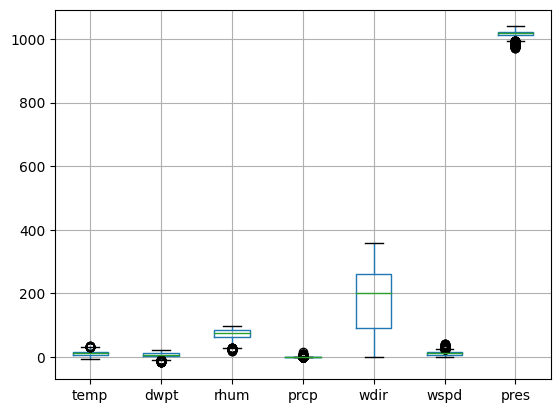

In [6]:
# TODO: make a nice boxplot and a bit more analysis on weather data 
weather_data.boxplot()

As we can see above, we did some initial changes to our dataset, namely changing the column names, selecting the date range we are interested in, dropping the columns where all values where *NaN*, and concatenating the date and hour columns in order to have the date in the same formate as the *bike_count*.
After this initial step in preparing our data, we can see that we still have some missing values in the precipitation column (around 10%). In order to tackle this problem, we are going to do multivariate feature amputation in order to predict the missing values. 

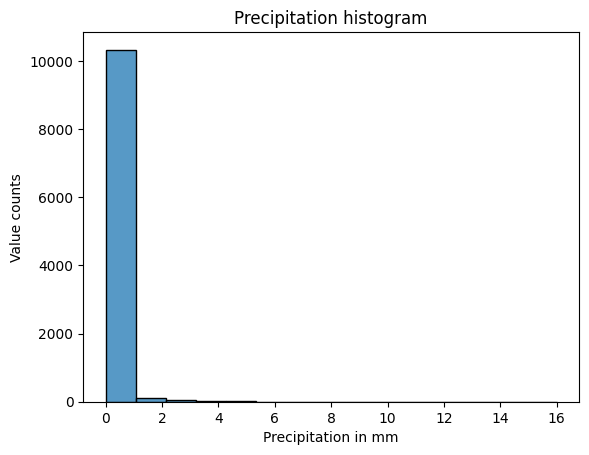

In [7]:
# TODO: make this clearer
sns.histplot(weather_data['prcp'], )
plt.xlabel('Precipitation in mm')
plt.ylabel('Value counts')
plt.title('Precipitation histogram')
plt.show()



In [8]:
weather_data['prcp'].describe()

count    10505.000000
mean         0.092832
std          0.459733
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         16.000000
Name: prcp, dtype: float64

In [129]:
index_of_na = weather_data[weather_data['prcp'].isna()].index


In [126]:
# impute percipitation based on all other weather data except the date and wdir
unused_cols = ["date","wdir"]
#imp = IterativeImputer(random_state=0)
imp = KNNImputer(n_neighbors=10)
transformed_data = imp.fit_transform(weather_data.drop(columns=unused_cols))

weather_data_imp = weather_data.copy()
weather_data_imp[weather_data_imp.columns.difference(unused_cols,sort=False)] = transformed_data


In [119]:
weather_data_imp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11604 entries, 180135 to 191738
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    11604 non-null  datetime64[ns]
 1   temp    11604 non-null  float64       
 2   dwpt    11604 non-null  float64       
 3   rhum    11604 non-null  float64       
 4   prcp    11604 non-null  float64       
 5   wdir    11604 non-null  float64       
 6   wspd    11604 non-null  float64       
 7   pres    11604 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 1.0 MB


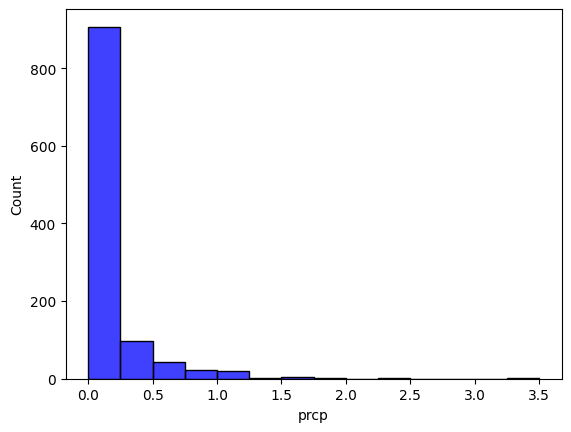

In [128]:
imputed_values = weather_data_imp.loc[index_of_na,['prcp']]
#run next line to get two histograms overlapping
#sns.histplot(weather_data['prcp'],binwidth=0.25 , binrange=[0,5], color='orange')
sns.histplot(imputed_values['prcp'], binwidth=0.25, color='blue')
plt.show()

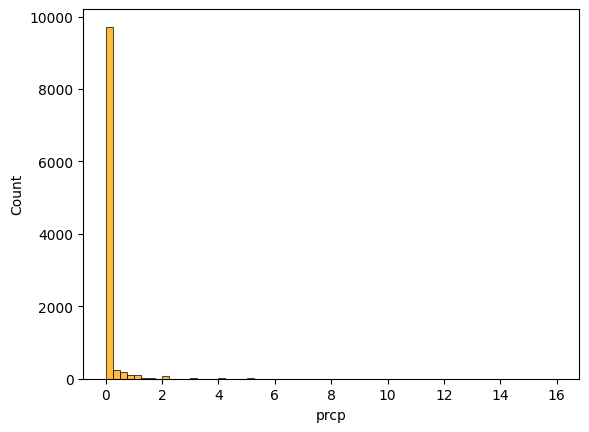

In [121]:
sns.histplot(weather_data['prcp'],binwidth=0.25 , color='orange')
plt.show()

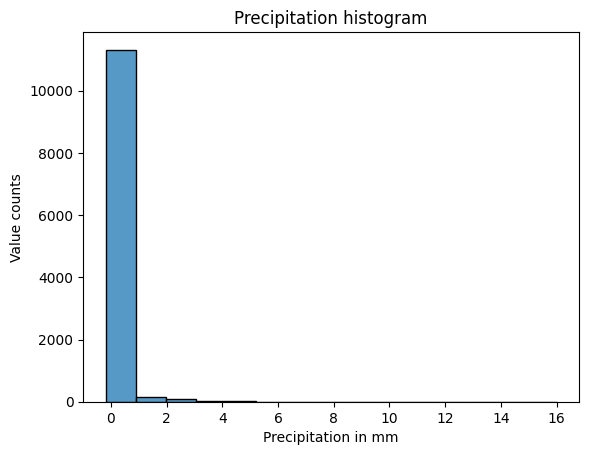

In [48]:
# TODO: make this clearer
sns.histplot(weather_data_imp['prcp'])
plt.xlabel('Precipitation in mm')
plt.ylabel('Value counts')
plt.title('Precipitation histogram')
plt.show()

In [49]:
weather_data_imp['prcp'].describe()

count    11604.000000
mean         0.098371
std          0.439557
min         -0.182261
25%          0.000000
50%          0.000000
75%          0.000000
max         16.000000
Name: prcp, dtype: float64

In [52]:
weather_data_imp['prcp'].lt(0).sum()

158

In [15]:
# safe clean weather data without imputation
weather_data.to_csv("../data/weather_data.csv")

# safe weather data with imputed values
weather_data_imp.to_csv("../data/weather_data_imp.csv")